# 10.7 Group Project: Report
# Covid Data Analysis
Theoretical explanation: What kind of machine learning problems these are and why you are using a particular technique/algorithm. [20 points]

Practical explanation: The importance of this topic/phenomena in society, technology, and/or business area. [20 points]

topic introduction, explanation of the problems studied, methods used, their justification, results and discussion/insights from those results.

When the COVID-19 virus turned into a worldwide pandemic in early 2020, most hospitals around the world ceased elective surgeries to prevent further infection and reduce deaths. This was especially true in the months leading up to the first vaccine's widespread availability in early 2021. Hospital administrators and physicians needed to carefully choose when to resume and when to pause so as not to overwhelm their hospitals with even more patients.<p>
As data became increasingly available, hospitals turned to data scientists and analysts to help them predict when they might be able to reopen. Initially, these predictions were not very accurate. As more data became available and reliability increased, they could use the data to predict whether there would be a surge in infections or deaths.<p>
Using seroprevalence (does your blood contain a chemical that indicates you had the COVID virus or were vaccinated), case, death, demographics and vaccine data primarily from the US Centers for Disease Control (CDC), we will predict if COVID cases and deaths to know when we can open hospitals to elective surgery.<p>
We will answer the following questions:<p>
1. Were some states worse off than others? I.e., could we resume operations in one state, but not in another? Could we categorize the states into high, medium, and low risk categories?
2. What are the most powerful leading indicators for forecasting a surge in infections?
3. Given the demographic, seroprevalence, and vaccine data, could we predict when deaths due to COVID would decline to an acceptable level?
4. 
5. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [230]:
# Import Case, Death, Seoprevalence data to cluster the states
covid_data = pd.read_csv("death_sero.csv")
print("Dataset shape:", covid_data.shape)
covid_data_agg = covid_data.groupby('state').agg({
    'tot_cases': 'max',
    'tot_deaths': 'max', 
    'n_samples': 'mean',
    'n_infected': 'mean'
}).reset_index()
display(covid_data_agg.head(3))

Dataset shape: (10479, 6)


,state,tot_cases,tot_deaths,n_samples,n_infected
0,AK,297588.0,1468.0,28991.348718,1157.076923
1,AL,1659936.0,21138.0,66436.817766,1861.851064
2,AR,995043.0,13115.0,37584.462609,1326.706522


In [231]:
display(covid_data_agg[covid_data_agg.isna().any(axis=1)])

,state,tot_cases,tot_deaths,n_samples,n_infected
3,AS,8331.0,34.0,NaN,NaN
11,FSM,26453.0,64.0,NaN,NaN
13,GU,61642.0,415.0,NaN,NaN
28,MP,13886.0,44.0,NaN,NaN
39,NYC,3266726.0,45181.0,NaN,NaN
45,PW,6000.0,9.0,NaN,NaN
47,RMI,16081.0,17.0,NaN,NaN
54,VI,24994.0,131.0,NaN,NaN


In [232]:
# The minor outlying states and NYC have some but not all data, so we'll filter them out
covid_data_agg = covid_data_agg.dropna()
display(covid_data_agg[covid_data_agg.isna().any(axis=1)])

,state,tot_cases,tot_deaths,n_samples,n_infected


# Question 1

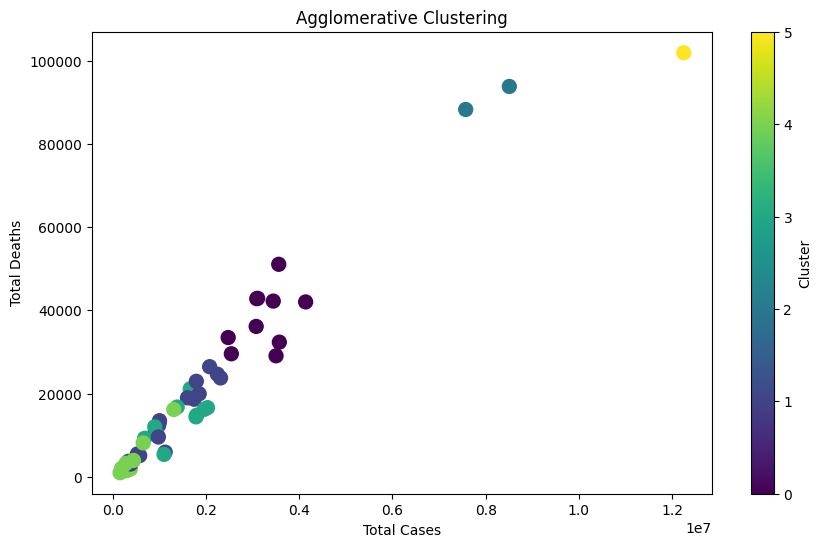

In [233]:
# Build Agglomerative Cluster to see which states are clustered together
covid_related = covid_data_agg[['tot_cases', 'tot_deaths', 'n_samples', 'n_infected']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(covid_related)
model = AgglomerativeClustering(n_clusters=6)
model.fit(scaled_features) 
# Scatterplot
x = covid_related['tot_cases']
y = covid_related['tot_deaths']
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=model.labels_, cmap='viridis', s=100)
plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.title('Agglomerative Clustering')
plt.colorbar(label='Cluster')

Question 1.<p>
We have 6 clusters, but three of them are not well separated at all. We'll do a Dendogram to see if we get better clustering. Let's look at trying different number of clusters.

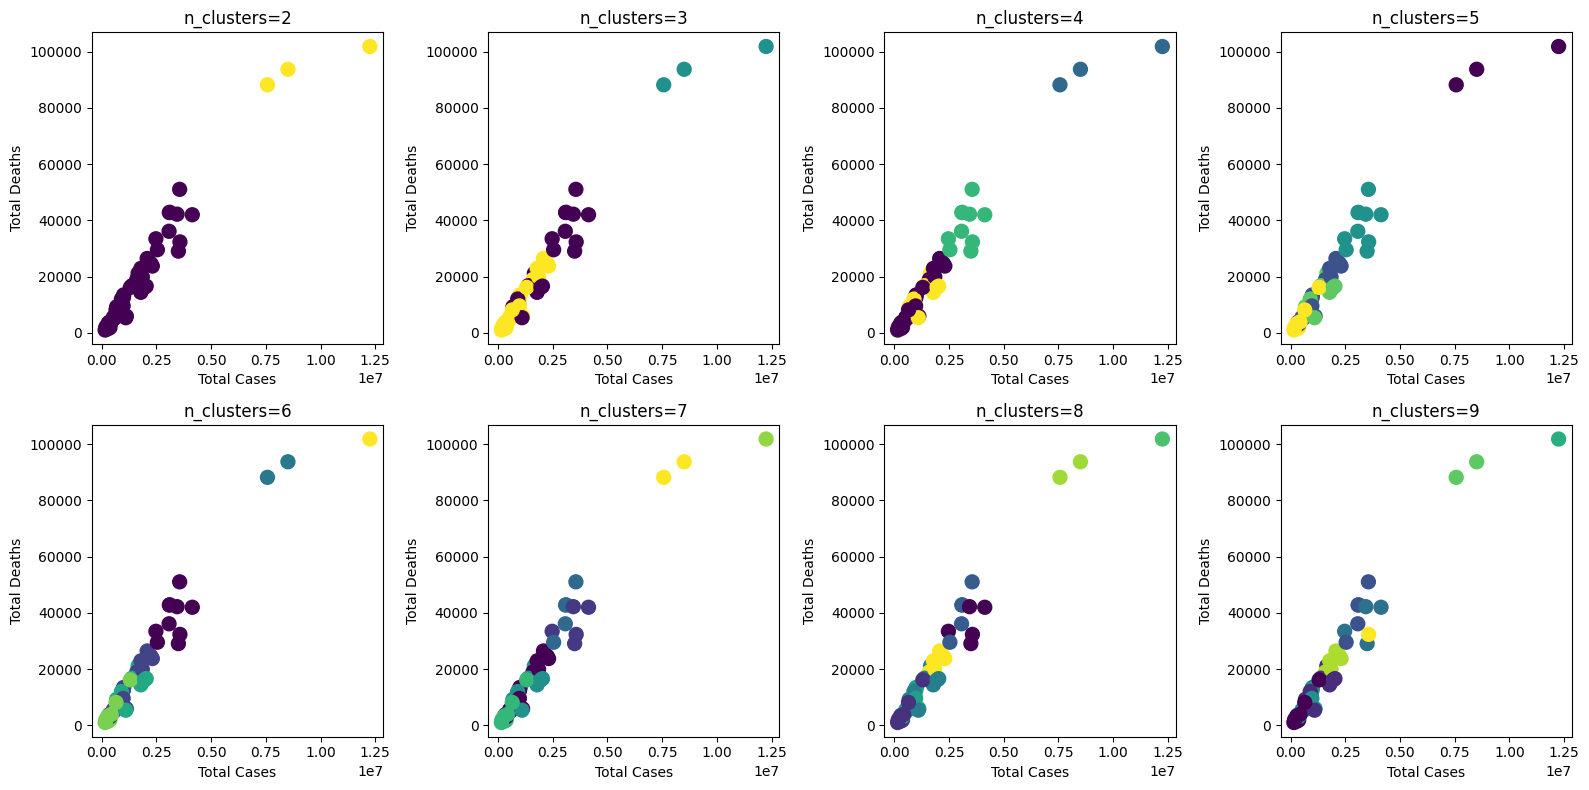

In [234]:
# Create a grid of scatter plots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, n_clusters in enumerate(range(2, 10)):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model.fit(scaled_features)
    
    # Scatter plot
    x = covid_related['tot_cases']
    y = covid_related['tot_deaths']
    axes[i].scatter(x, y, c=model.labels_, cmap='viridis', s=100)
    axes[i].set_title(f'n_clusters={n_clusters}')
    axes[i].set_xlabel('Total Cases')
    axes[i].set_ylabel('Total Deaths')

plt.tight_layout()
plt.show()

Question 1 continued.<p>
Two clusters are well defined, but very skewed with one cluster only having three states. All of the rest of the clusters do have good enough distinctions for cases and deaths.

Agglomerative Clustering Silhouette Score: 0.3784315824054109


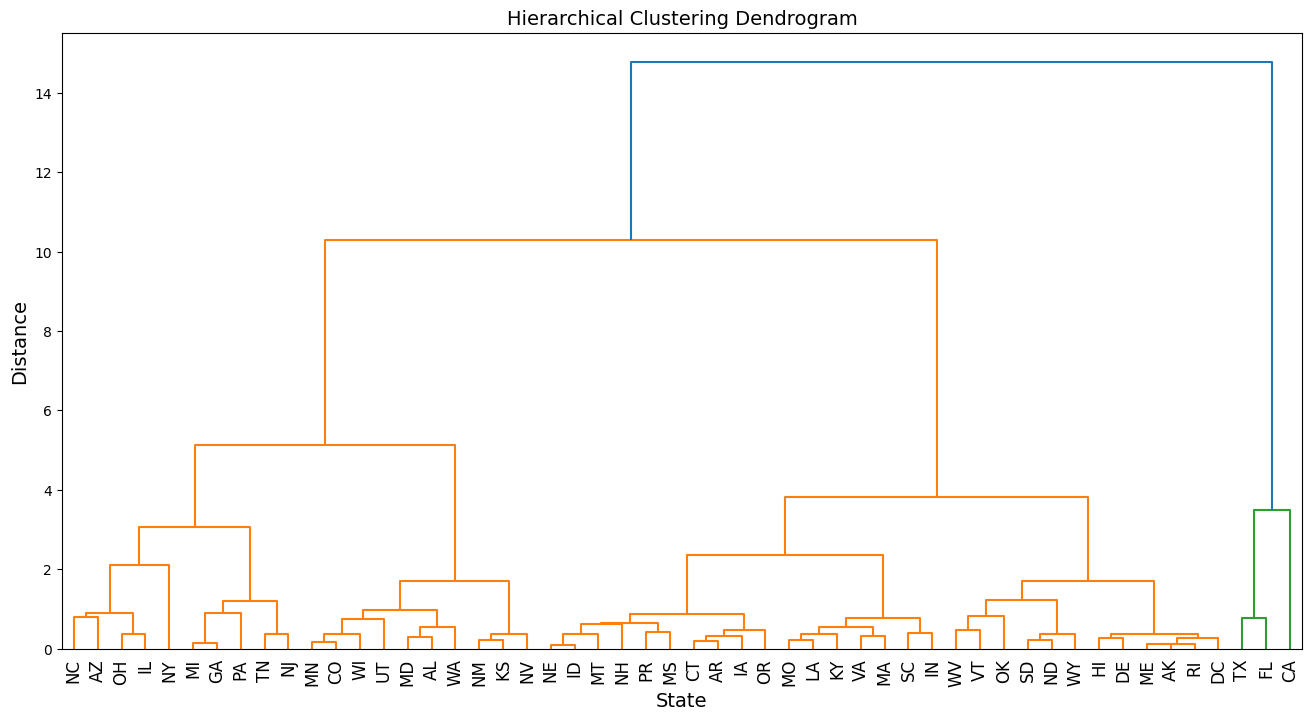

In [235]:
# Dendrogram
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(16, 8))
dendrogram(linked,
           labels=covid_data_agg['state'].values,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_font_size=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.xticks(rotation=90)
# Calculate silhouette score
score = silhouette_score(scaled_features, model.labels_)
print("Agglomerative Clustering Silhouette Score:", score)

Question 1 continued.<p>
These two clustering techniques do not seem to be clustering the data correctly. For example, we see TX, FL and CA all in the same cluster, but if we look at there data, we can see that something is wrong.

In [236]:
filtered_df = covid_data_agg[covid_data_agg["state"].isin(["CA", "FL", "TX"])]
filtered_df.head()

,state,tot_cases,tot_deaths,n_samples,n_infected
5,CA,12251820.0,101886.0,148665.085851,3738.127660
10,FL,7572282.0,88248.0,97133.773478,2771.826087
51,TX,8508204.0,93780.0,112830.843805,2751.478261


In [237]:
# Extract and isolate Population by State
nat_sero_pop = pd.read_csv("Nationwide_Commercial_Laboratory_Seroprevalence_Survey.csv")
nat_sero_pop.rename(columns={'Site': 'state', 'Catchment population': 'state_population'}, inplace=True)
# There are aggregates in the data, like nationwide, filter them out
nat_sero_pop = nat_sero_pop[nat_sero_pop["Catchment Area Description"] == 'Statewide']
state_pop = nat_sero_pop.groupby('state')['state_population'].mean().reset_index()
display(state_pop.head(3))
# Add in state_population so we can do rates per 100K etc
covid_data = covid_data.merge(state_pop, on='state', how='left')
covid_data_agg = covid_data.groupby('state').agg({
    'state_population': 'max',
    'tot_cases': 'max',
    'tot_deaths': 'max', 
    'n_samples': 'mean',
    'n_infected': 'mean'
}).reset_index()
display(covid_data_agg.head(3))


,state,state_population
0,AK,6.578534e+05
1,AL,4.321031e+06
2,AR,2.660818e+06


,state,state_population,tot_cases,tot_deaths,n_samples,n_infected
0,AK,6.578534e+05,297588.0,1468.0,28991.348718,1157.076923
1,AL,4.321031e+06,1659936.0,21138.0,66436.817766,1861.851064
2,AR,2.660818e+06,995043.0,13115.0,37584.462609,1326.706522


Question 1 continued.<p>
California has twice the population of Florida, yet, they have the total number of deaths that is about the same. Obviously, we need to factor in population so that the raw numbers are not hiding any details or skewing results.

In [238]:
# Helper function to calculate percapita data
def create_percapita(df, target_col_name, numerator_col_name, denominator_col_name = 'state_population'):
    df.loc[:, target_col_name] = np.where(
    df[denominator_col_name] > 0,
    (df[numerator_col_name] / df[denominator_col_name]) * 100000, 0)
    return df

In [239]:
covid_data_agg = create_percapita(covid_data_agg, 'cases_per_100k', 'tot_cases', 'state_population')
covid_data_agg = create_percapita(covid_data_agg, 'deaths_per_100k', 'tot_deaths', 'state_population')
covid_data_agg = create_percapita(covid_data_agg, 'case_fatality_rate', 'tot_deaths', 'tot_cases')
covid_data_agg = create_percapita(covid_data_agg, 'infection_rate', 'n_infected', 'n_samples')
covid_data_agg.head(3)

,state,state_population,tot_cases,tot_deaths,n_samples,n_infected,cases_per_100k,deaths_per_100k,case_fatality_rate,infection_rate
0,AK,6.578534e+05,297588.0,1468.0,28991.348718,1157.076923,45236.216317,223.150011,493.299461,3991.111053
1,AL,4.321031e+06,1659936.0,21138.0,66436.817766,1861.851064,38415.273814,489.188775,1273.422590,2802.438657
2,AR,2.660818e+06,995043.0,13115.0,37584.462609,1326.706522,37396.137589,492.893618,1318.033492,3529.933461


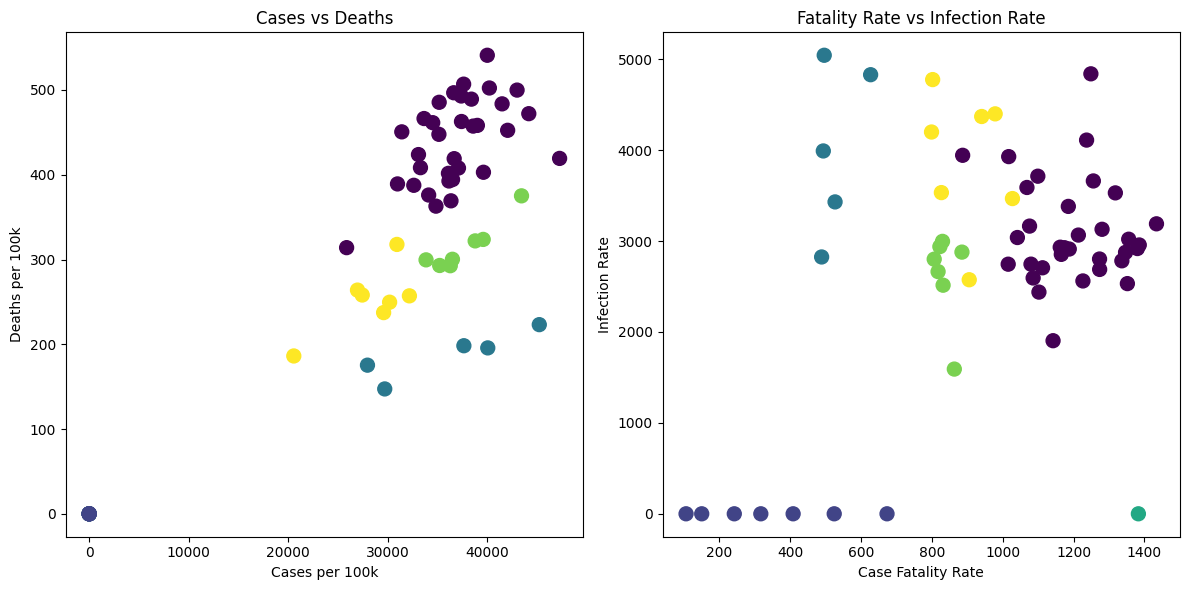

In [240]:
# Display Scatter Plot with percapita data to see if clusters are mode defined
covid_related = covid_data_agg[['cases_per_100k', 'deaths_per_100k', 'case_fatality_rate', 'infection_rate']]
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(covid_related)

# Fit the clustering model
model = AgglomerativeClustering(n_clusters=6)
model.fit(scaled_features)

# Scatter plot data
x1 = covid_data_agg['cases_per_100k']
y1 = covid_data_agg['deaths_per_100k']
x2 = covid_data_agg['case_fatality_rate']
y2 = covid_data_agg['infection_rate']

# Create side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First scatter plot: Cases vs Deaths
axes[0].scatter(x1, y1, c=model.labels_, cmap='viridis', s=100)
axes[0].set_xlabel('Cases per 100k')
axes[0].set_ylabel('Deaths per 100k')
axes[0].set_title('Cases vs Deaths')

# Second scatter plot: Fatality Rate vs Infection Rate
axes[1].scatter(x2, y2, c=model.labels_, cmap='viridis', s=100)
axes[1].set_xlabel('Case Fatality Rate')
axes[1].set_ylabel('Infection Rate')
axes[1].set_title('Fatality Rate vs Infection Rate')

plt.tight_layout()
plt.show()

Question 1 continued.<p>
Cases and Deaths are nicely clustered. The Fatality & Infection rate clusters are separated, but not as good as Cases & Deaths.

Agglomerative Clustering Silhouette Score: 0.3898519619146974


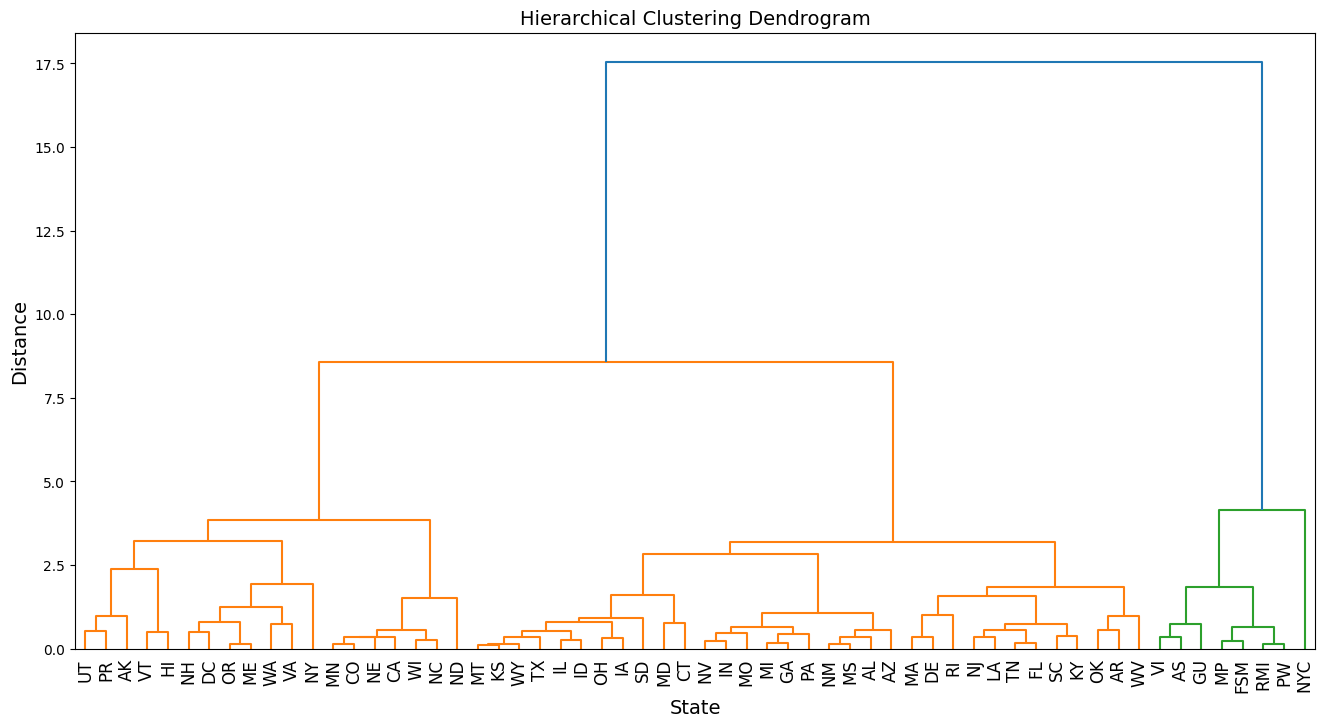

In [241]:
# Dendrogram with percapita features
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(16, 8))
dendrogram(linked,
           labels=covid_data_agg['state'].values,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_font_size=12)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.xticks(rotation=90)
# Calculate silhouette score
score = silhouette_score(scaled_features, model.labels_)
print("Agglomerative Clustering Silhouette Score:", score)

Question 1 continued.<p>
Now we see CA with states like Minnesota, Colorado and North Carolina which had similar policies in place at the time. This clustering makes much more sense than the first one.

# Question 2
What are the best predictors?

# Question 3
When can we open?

In [256]:
death_sero_data_weekly = pd.read_csv('death_sero.csv')
death_sero_data_weekly = pd.merge(death_sero_data_weekly, state_pop, on = 'state', how = 'outer')
death_sero_data_weekly = create_percapita(death_sero_data_weekly, 'cases_per_100k', 'tot_cases', 'state_population')
death_sero_data_weekly = create_percapita(death_sero_data_weekly, 'deaths_per_100k', 'tot_deaths', 'state_population')
death_sero_data_weekly = create_percapita(death_sero_data_weekly, 'case_fatality_rate', 'tot_deaths', 'tot_cases')
death_sero_data_weekly = create_percapita(death_sero_data_weekly, 'infection_rate', 'n_infected', 'n_samples')
death_sero_data_weekly

,state,tot_cases,tot_deaths,year_week,n_samples,n_infected,state_population,cases_per_100k,deaths_per_100k,case_fatality_rate,infection_rate
0,AK,0.0,0.0,2020-W03,NaN,NaN,657853.428571,0.000000,0.000000,0.000000,0.0
1,AK,0.0,0.0,2020-W04,NaN,NaN,657853.428571,0.000000,0.000000,0.000000,0.0
2,AK,0.0,0.0,2020-W05,NaN,NaN,657853.428571,0.000000,0.000000,0.000000,0.0
3,AK,0.0,0.0,2020-W06,NaN,NaN,657853.428571,0.000000,0.000000,0.000000,0.0
4,AK,0.0,0.0,2020-W07,NaN,NaN,657853.428571,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10474,WY,186284.0,2023.0,2023-W15,NaN,NaN,517278.000000,36012.356992,391.085644,1085.976251,0.0
10475,WY,186399.0,2027.0,2023-W16,NaN,NaN,517278.000000,36034.588751,391.858923,1087.452186,0.0
10476,WY,186539.0,2030.0,2023-W17,NaN,NaN,517278.000000,36061.653502,392.438882,1088.244281,0.0
10477,WY,186668.0,2031.0,2023-W18,NaN,NaN,517278.000000,36086.591736,392.632202,1088.027943,0.0


We need to come up with a benchmark for what constitutes unnacceptable. Since we are trying to determine if hospitals are being overwhelmed, we will focus on cases and not deaths. We will use South Korea as a benchmark since they had one of the fewest death rates of any country throughout the pandemic(1). However, we will have to increase the threshold because the US was much worse than South Korea; if <500 per 100K weekly case rate was good for South Korea, we will have to multiply the US rate by 10 to get 5,000. 

Reference (1): Choi, O., & Kim, S. (2024). Comparison of the efficacy of COVID-19 responses in South Korea and the United States. Global Health Action, 17(1). https://doi.org/10.1080/16549716.2024.2370611

In [243]:
world_data = pd.read_csv('daily-new-confirmed-covid-19-cases-per-million-people.csv')
world_data.columns = ['country', 'date', 'new_cases_perM']
world_data['date'] = pd.to_datetime(world_data['date'])
world_data['week'] = world_data['date'].dt.to_period('W').apply(lambda r: r.start_time)
world_data['new_cases_per100K'] = world_data['new_cases_perM'] / 10
filtered_df = world_data[world_data["country"].isin(["South Korea"])]
filtered_df = filtered_df[filtered_df['new_cases_per100K'] > 0]
display(filtered_df.tail(3))

,country,date,new_cases_perM,week,new_cases_per100K
403629,South Korea,2023-09-08,373.35025,2023-09-04,37.335025
403630,South Korea,2023-09-09,373.35025,2023-09-04,37.335025
403631,South Korea,2023-09-10,373.35025,2023-09-04,37.335025


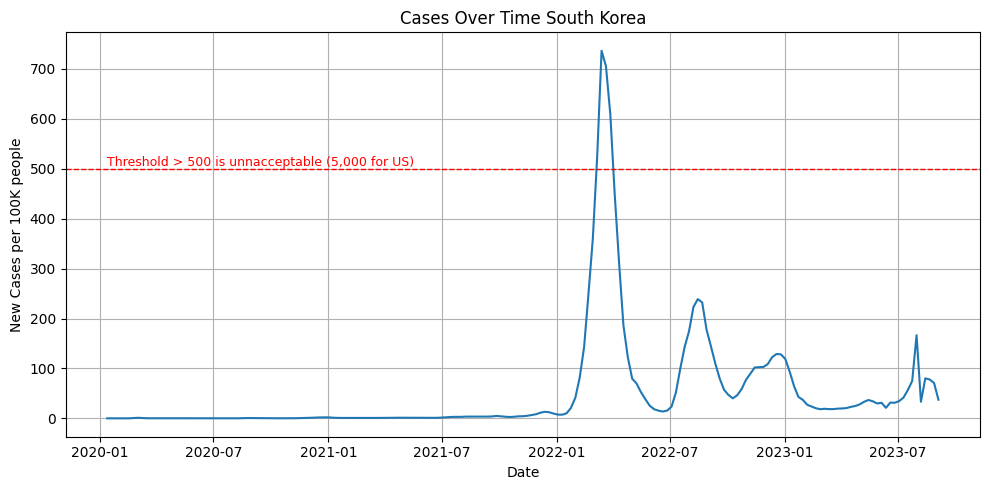

In [244]:
weekly_avg = filtered_df.groupby('week')['new_cases_per100K'].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(weekly_avg['week'], weekly_avg['new_cases_per100K'], markersize=1)
plt.axhline(y=500, color='red', linestyle='--', linewidth=1)
plt.text(weekly_avg['week'].iloc[0], 505, 'Threshold > 500 is unnacceptable (5,000 for US)', color='red', fontsize=9)
plt.title('Cases Over Time South Korea')
plt.xlabel('Date')
plt.ylabel('New Cases per 100K people')
plt.grid(True)
plt.tight_layout()
plt.show()

In [261]:
covid_data

,state,tot_cases,tot_deaths,year_week,n_samples,n_infected,state_population
0,AK,0.0,0.0,2020-W03,NaN,NaN,657853.428571
1,AK,0.0,0.0,2020-W04,NaN,NaN,657853.428571
2,AK,0.0,0.0,2020-W05,NaN,NaN,657853.428571
3,AK,0.0,0.0,2020-W06,NaN,NaN,657853.428571
4,AK,0.0,0.0,2020-W07,NaN,NaN,657853.428571
...,...,...,...,...,...,...,...
10474,WY,186284.0,2023.0,2023-W15,NaN,NaN,517278.000000
10475,WY,186399.0,2027.0,2023-W16,NaN,NaN,517278.000000
10476,WY,186539.0,2030.0,2023-W17,NaN,NaN,517278.000000
10477,WY,186668.0,2031.0,2023-W18,NaN,NaN,517278.000000


In [259]:
vaccine_data

,outcome,boosted_with_outcome,boosted_population,primary_series_only_with_outcome,primary_series_only_population,unvaccinated_with_outcome,unvaccinated_population,crude_booster_ir,crude_primary_series_only_ir,crude_unvax_ir,crude_booster_irr,crude_irr,age_adj_booster_ir,age_adj_vax_ir,age_adj_unvax_ir,age_adj_booster_irr,age_adj_irr,year_week
0,case,546,1562854,107943,111647895,240670,49474362.80,34.936085,96.681626,486.453966,13.924112,5.031504,37.618216,97.743583,487.492642,12.958952,4.987464,2021-W38
1,case,624,1898762,102107,112762094,204700,48423938.80,32.863518,90.550819,422.724803,12.863042,4.668371,37.710445,91.303257,426.371625,11.306460,4.669840,2021-W39
2,case,746,2315541,96205,113676350,180689,47500945.80,32.217093,84.630620,380.390321,11.807096,4.494713,39.582996,85.177244,385.323914,9.734582,4.523789,2021-W40
3,case,896,3983836,86980,113130056,155652,46689549.80,22.490886,76.884962,333.376528,14.822739,4.336043,27.623276,77.145609,340.206551,12.315938,4.409928,2021-W41
4,case,1196,5945158,82286,112184292,141203,45959133.50,20.117211,73.348950,307.235993,15.272295,4.188690,22.607625,73.488728,313.852581,13.882599,4.270758,2021-W42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,death,618,69092145,442,73404013,681,51234309.35,0.894458,0.602147,1.329187,1.486026,2.207414,0.418870,0.604904,2.979486,7.113148,4.925550,2022-W31
99,death,580,69411521,347,73201496,655,51119502.95,0.835596,0.474034,1.281311,1.533410,2.702994,0.380097,0.474500,2.873882,7.560920,6.056654,2022-W32
100,death,505,69682742,301,73036880,539,51020655.95,0.724713,0.412121,1.056435,1.457728,2.563412,0.337574,0.415599,2.375381,7.036617,5.715566,2022-W33
101,death,400,69917794,242,72901928,446,50928516.95,0.572100,0.331953,0.875737,1.530740,2.638138,0.269121,0.331234,1.963168,7.294754,5.926829,2022-W34


In [258]:
# Add in vaccination data
vaccine_data = pd.read_csv('vaccine.csv')
# Join but we have two rows now with outcome death and case and we need to aggregate that at some point
covid_vaccine = pd.merge(death_sero_data_weekly, vaccine_data, on = 'year_week', how = 'full')
covid_vaccine = covid_vaccine.dropna()
covid_vaccine = covid_vaccine.replace([None, np.nan, np.inf, -np.inf], 0)
display(covid_vaccine.head)

UnboundLocalError: local variable 'lidx' referenced before assignment

In [245]:
# Compute weekly cases per state
state_aggregates = covid_vaccine.groupby(['state', 'year_week']).agg({
    'age_adj_booster_ir': 'sum',
    'age_adj_booster_irr': 'sum',
    'age_adj_irr': 'sum',
    'age_adj_vax_ir': 'sum',
    'crude_booster_ir': 'sum',
    'crude_booster_irr': 'sum',
    'crude_irr': 'sum',
    'crude_primary_series_only_ir': 'sum',
    'crude_unvax_ir': 'sum',
    'cases_per_100k': 'max', 
    'deaths_per_100k': 'max',
    'case_fatality_rate': 'max',
    'infection_rate': 'max'
}).reset_index()
state_aggregates

,state,year_week,age_adj_booster_ir,age_adj_booster_irr,age_adj_irr,age_adj_vax_ir,crude_booster_ir,crude_booster_irr,crude_irr,crude_primary_series_only_ir,crude_unvax_ir,cases_per_100k,deaths_per_100k,case_fatality_rate,infection_rate
0,AK,2021-W39,38.513667,25.023850,20.052409,92.019529,34.184531,18.854416,12.365769,91.579048,430.639485,16709.345156,85.581374,512.176706,1708.718523
1,AK,2021-W40,40.181455,26.381055,20.714233,85.792560,33.436588,17.548941,12.426506,85.513416,387.392473,17582.487979,88.317545,502.304028,2840.909091
2,AK,2021-W44,32.970600,40.176376,17.190792,86.451671,24.668773,22.535132,10.692689,84.798463,326.638166,20693.515316,111.422996,538.444022,1618.392195
3,AK,2021-W48,46.079594,68.508741,17.138691,152.017109,37.282519,29.782296,11.371703,150.977818,556.412389,22270.614340,133.312370,598.602124,1583.232889
4,AK,2021-W52,760.877750,27.871956,9.239267,1268.910295,642.285028,10.141787,6.044905,1249.834027,2599.481787,23160.630223,148.057296,639.262813,2433.090024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,WY,2021-W48,46.079594,68.508741,17.138691,152.017109,37.282519,29.782296,11.371703,150.977818,556.412389,21489.411883,275.867135,1283.735157,1098.554245
399,WY,2022-W02,938.697996,23.834040,8.993694,1390.160308,802.742192,9.032802,5.933521,1375.095116,3087.404963,24089.947765,306.991598,1274.355600,1879.699248
400,WY,2022-W05,284.220033,24.573926,10.505458,321.434411,267.032195,8.867667,6.821173,320.113536,853.878698,28846.384343,318.977416,1105.779541,1600.000000
401,WY,2022-W13,69.751744,10.738177,9.126648,31.346269,62.045381,4.013810,6.108011,31.127497,76.339536,30274.049931,346.235487,1143.670858,1183.585270


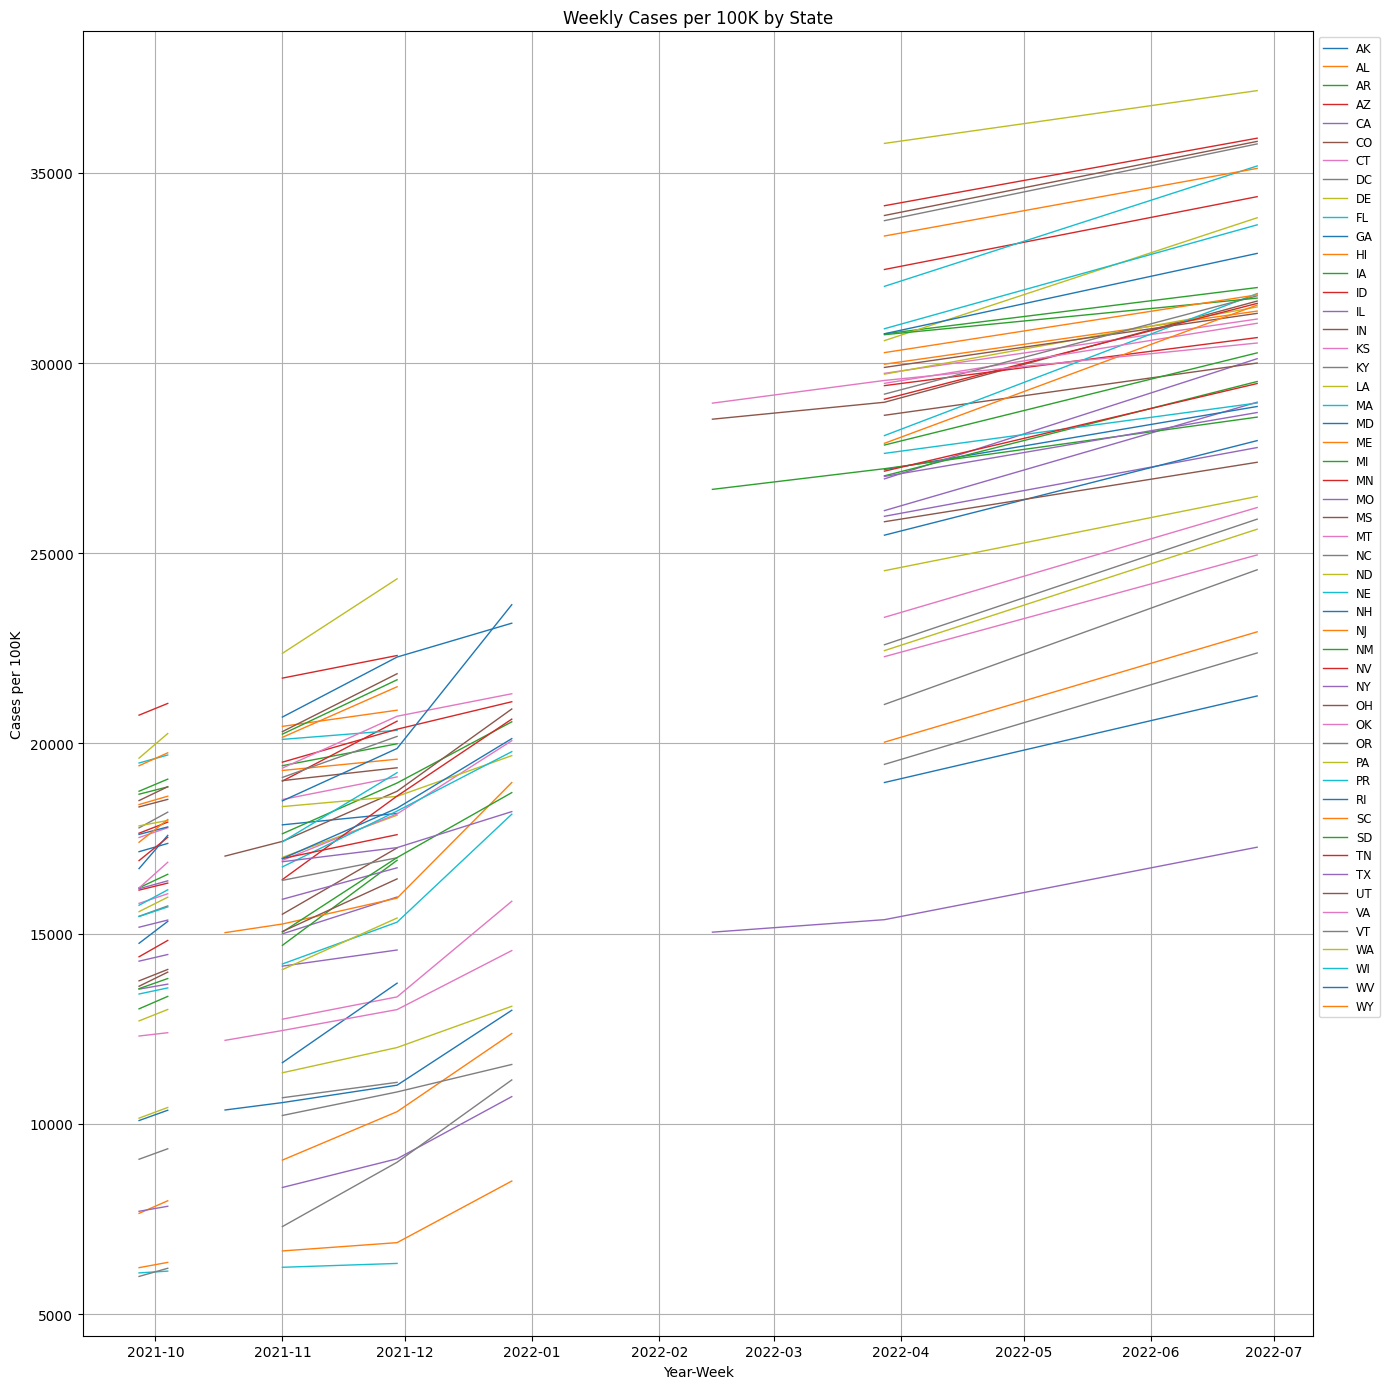

In [246]:
# Pivot so each state becomes a column
state_aggregates['year_week_dt'] = pd.to_datetime(state_aggregates['year_week'] + '-1', format='%Y-W%W-%w')
pivot_df = state_aggregates.pivot(index='year_week_dt', columns='state', values='cases_per_100k')
pivot_df = pivot_df.sort_index()
# Plot
plt.figure(figsize=(14, 14))
for state in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[state], label=state, linewidth=1)
plt.title('Weekly Cases per 100K by State')
plt.xlabel('Year-Week')
plt.ylabel('Cases per 100K')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='small')
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
state_aggregates['unacceptable'] = (state_aggregates['cases_per_100k'] > 5000).astype(int)
display(state_aggregates[state_aggregates['cases_per_100k'] > 5000])

In [ ]:
# Binary label: 1 = unacceptable if >= 1 death/100k, else 0
state_aggregates['unacceptable'] = (state_aggregates['cases_per_100k'] > 50000).astype(int)

x_cols = ['crude_booster_ir', 'crude_primary_series_only_ir', 'crude_unvax_ir',
          'crude_booster_irr', 'crude_irr', 'age_adj_booster_ir', 'age_adj_vax_ir', 
          'age_adj_unvax_ir', 'age_adj_booster_irr', 'age_adj_irr', 'weekly_deaths', 
          'deaths_per_100k', 'state_population', 'cases_per_100k', 'case_fatality_rate', 'infection_rate']
x = covid_vaccine[x_cols]
y = covid_vaccine.loc[x.index, 'unacceptable']

# Split and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 42)

model = LogisticRegression(class_weight = 'balanced', max_iter = 50)
model.fit(x_train, y_train)

# Predict and evaluate
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
x

In [ ]:
print("Unique values in y (full dataset):", y.unique())
print("Value counts in y (full dataset):\n", y.value_counts())
print("\nUnique values in y_train:", y_train.unique())
print("Value counts in y_train:\n", y_train.value_counts())
print("\nUnique values in y_test:", y_test.unique())
print("Value counts in y_test:\n", y_test.value_counts())